### 여러분들은 자금을 받아 펀드를 운용하는 펀드매니저입니다. 어느날, 한 고객이 찾아와 돈을 맡기면서 다음의 조건에 맞는 포트폴리오를 구성해달라고 합니다. 이를 바탕으로 다음의 질문에 답하시오.

- 다음의 주식들로 포트폴리오를 구성: 삼성전자, 엔씨소프트, SK하이닉스, 카카오, 네이버
- 2019.1.1 ~ 2020.1.1의 일별데이터를 사용.
- 수익률은 ${P_t - P_{t-1}}\over{P_{t-1}}$로 구함. 이때, $t$는 daily frequency를 의미함.
- 위험자산 중 60%는 삼성전자 주식으로 구성(무위험자산은 고려 x).
- 포트폴리오에 포함되는 모든 자산의 가중치는 0 ~ 100% 사이.
- 위험 한 단위 대비 기대수익률이 가장 높은 포트폴리오를 구성.

1. 삼성전자의 가중치는 60%로 고정하고, 나머지 가중치들을 무작위로 부여한 random portfolio를 5,000개 생성해 위험자산들로만 이루어진 mean-variance frontier를 도출하시오.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web

data = pd.DataFrame()
for code in ['005930','036570','000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

data.columns = ['se', 'nc', 'skh', 'kk','nvr']
noa = len(data.columns)
data.head()

,se,nc,skh,kk,nvr
2019-01-02 00:00:00,38750,467000,60600,20473,118000
2019-01-03 00:00:00,37600,454500,57700,20573,122000
2019-01-04 00:00:00,37450,464000,58300,20774,125500
2019-01-07 00:00:00,38750,472500,58700,20673,131500
2019-01-08 00:00:00,38100,469000,59200,20051,130000


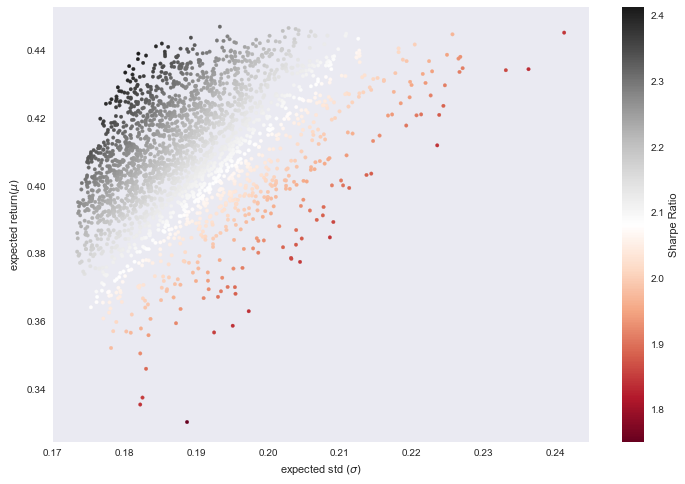

In [10]:
# get returns
ret = data.pct_change().dropna()

port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *252)
    port_var = np.dot(weight.T, np.dot(ret.cov()*252, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(2500):
    weight = np.random.random(noa-1)
    weight /= np.sum(weight)
    weight *= 0.4
    weight = np.array([0.6] + list(weight))
    mu, sig = ret_std(weight, ret)
#     print(mu, sig)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets)/np.array(port_std)
    
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, c=sr,marker='.',  cmap='RdGy')
plt.colorbar(label='Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid()

In [26]:
import scipy.optimize as opt

def statistics(weights, rf=0):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(ret.mean() * weights) * 252 - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol]) #기대수익률, 분산, sharpe ratio


In [33]:
def min_func_port(weights):
    return statistics(weights)[1]

cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

bnds = tuple([(0.6,0.6+1e-100)]+[(0, 1) for x in range(noa-1)])

trets = np.linspace(0.33, 0.44, 30)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP' ,
                   bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

No handles with labels found to put in legend.


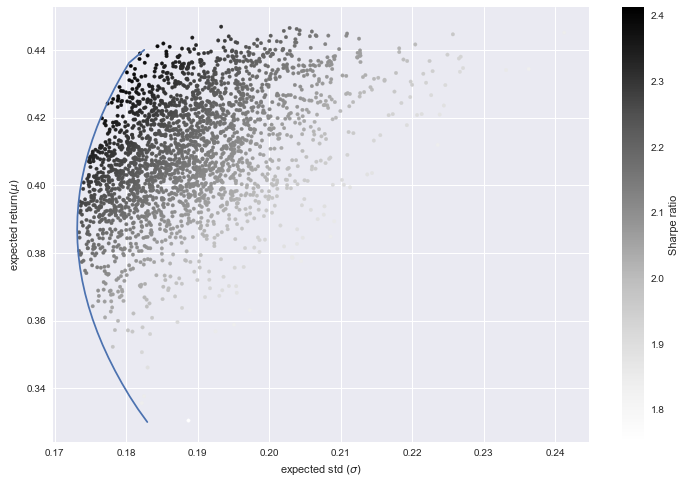

In [34]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(tvols, trets)
plt.legend()
plt.grid(True)
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.colorbar(label='Sharpe ratio')

2.  Risk-free rate이 0.02 일때, 무위험자산까지 포함한 mean-variance frontier를 도출하고 최적 포트폴리오의 가중치(각 종목별로) 및 최적 포트폴리오의 annualized sharpe-ratio를 구하시오 (1년을 252일로 계산).

In [35]:
import scipy.optimize as opt

def min_func_sharpe(weights, rf=0.02):
    return -statistics(weights, rf)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple([(0.6,0.6+1e-100)]+[(0, 1) for x in range(noa-1)])
noa * [1. / noa,]

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

opts

     fun: -2.3089879684564347
     jac: array([ 0.28488943, -0.16420278, -0.17615861, -0.70392969, -0.70377308])
 message: 'Optimization terminated successfully.'
    nfev: 22
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([6.00000000e-01, 5.23352669e-16, 0.00000000e+00, 2.08109047e-01,
       1.91890953e-01])

In [ ]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]

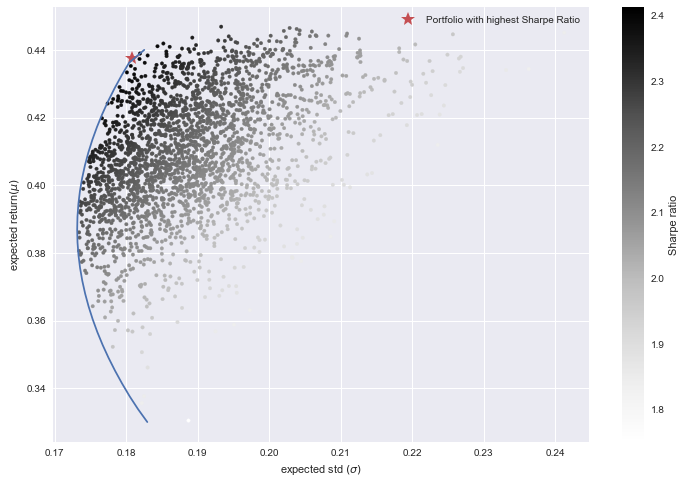

In [37]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
            # random portfolio composition=
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.plot(tvols, trets)
plt.legend()
plt.grid(True)
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.colorbar(label='Sharpe ratio')

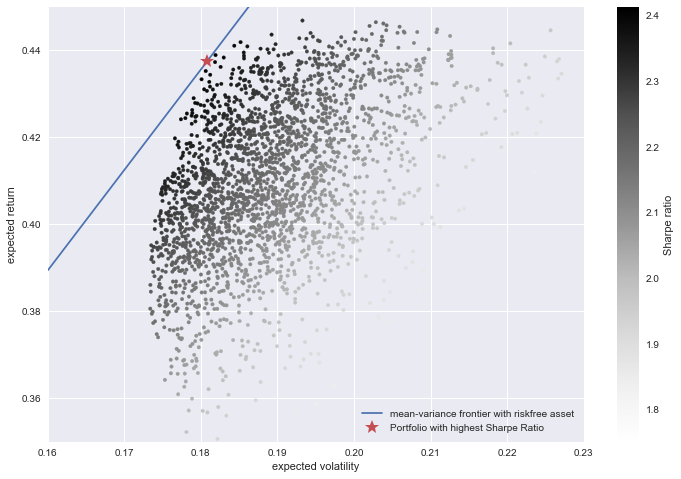

In [42]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]

x =  np.linspace(0.16,0.30,2500)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')
            # random portfolio composition  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.xlim((0.16, 0.23))
plt.ylim((0.35, 0.45))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')                    

In [43]:
opts

     fun: -2.3089879684564347
     jac: array([ 0.28488943, -0.16420278, -0.17615861, -0.70392969, -0.70377308])
 message: 'Optimization terminated successfully.'
    nfev: 22
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([6.00000000e-01, 5.23352669e-16, 0.00000000e+00, 2.08109047e-01,
       1.91890953e-01])

In [44]:
slope

2.3089879684564347

3. 위의 분석들을, 이번에는 '위험자산 중 60%는 삼성전자 주식으로 구성'이라는 조건을 제외하고 다시 진행하고 새로 구한 최적 포트폴리오의 annualized sharpe-ratio를 (3-2)의 것과 비교하시오. 펀드매니저로써 고객에게 어떤 포트폴리오를 추천하겠습니까?

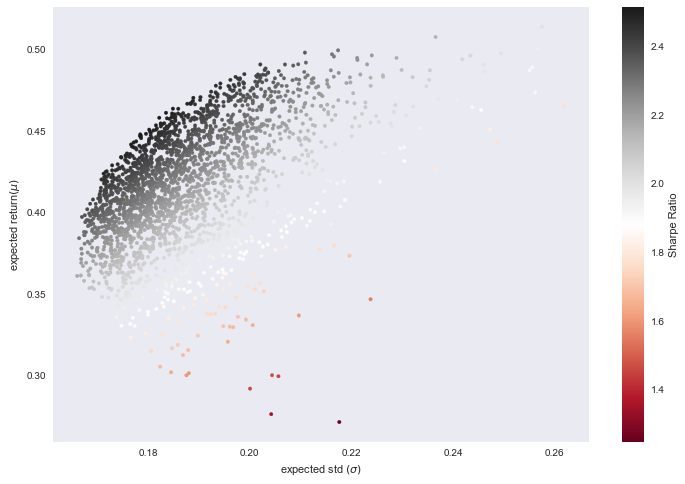

In [45]:
# get returns
ret = data.pct_change().dropna()

port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *252)
    port_var = np.dot(weight.T, np.dot(ret.cov()*252, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(2500):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    mu, sig = ret_std(weight, ret)
#     print(mu, sig)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets)/np.array(port_std)
    
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, c=sr,marker='.',  cmap='RdGy')
plt.colorbar(label='Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid()

In [48]:
def min_func_port(weights):
    return statistics(weights)[1]

cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

bnds = tuple([(0, 1) for x in range(noa)])

trets = np.linspace(0.3, 0.5, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP' ,
                   bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

No handles with labels found to put in legend.


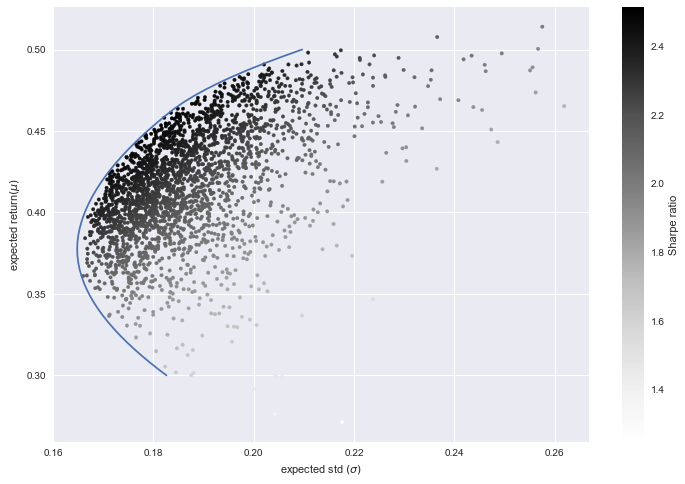

In [49]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(tvols, trets)
plt.legend()
plt.grid(True)
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.colorbar(label='Sharpe ratio')

In [50]:
import scipy.optimize as opt

def min_func_sharpe(weights, rf=0.02):
    return -statistics(weights, rf)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple([(0, 1) for x in range(noa)])
noa * [1. / noa,]

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

opts

     fun: -2.4095158849554723
     jac: array([-0.10904485, -0.0918324 , -0.10905808, -0.10881868, -0.108868  ])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.34073911, 0.        , 0.10693163, 0.29975559, 0.25257366])

In [51]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]

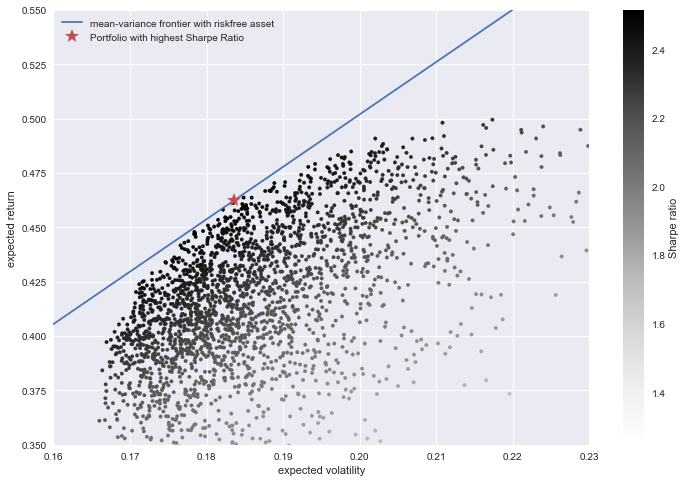

In [53]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]

x =  np.linspace(0.16,0.30,2500)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')
            # random portfolio composition  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.xlim((0.16, 0.23))
plt.ylim((0.35, 0.55))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')                    

In [54]:
slope

2.4095158849554723